In [1]:
import collections
import numpy as np
import optuna
import pandas as pd
import plotly
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (RepeatedKFold, cross_val_score,
                                     train_test_split)

# Load Data
wines = pd.read_csv("wines_encoded.csv", encoding='utf-8')
data_X = wines.drop(columns='points', inplace=False).values
data_Y = wines["points"].values
all_features = wines.drop(columns='points', inplace=False).columns
num_features = len(all_features)


# Select  Top Features
model = xgb.XGBRegressor(verbosity=1)
model.fit(data_X, data_Y)
print("Model Fitted")

# Select 100 best features
sorted_idx = model.feature_importances_.argsort()
selected_features = all_features[sorted_idx][num_features-300:num_features]
data_X_selected = wines[selected_features].values
selected_features_names = list(selected_features)


Model Fitted


In [9]:
# Data Prep for XGBoost
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    data_X_selected, data_Y, test_size=0.25, random_state=42)

# Encode Dmatrix
dtrain = xgb.DMatrix(X_train_2, label=y_train_2,
                     feature_names=selected_features_names)
dtest = xgb.DMatrix(X_test_2, label=y_test_2,
                    feature_names=selected_features_names)


# Set Optimize objective for Optuna and tune hyperparameters
def objective(trial, dtrain, dtest):

    param = {'booster': 'gbtree',
             "verbosity": 1,   # verbose=0   "silent": 0,
             'nthread': 6,
             'objective': 'reg:squarederror',
             'eval_metric': 'rmse',  # rmse   #mae
             'learning_rate': trial.suggest_loguniform('learning_rate', 0.0005, 1),
             'gamma': trial.suggest_loguniform("gamma", 1e-8, 0.5),
             'max_depth': trial.suggest_int('max_depth', 2, 20),
             "lambda": trial.suggest_loguniform("lambda", 1e-8, 3.0),
             "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
             'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1, 0.05)
             }
    # Pruning Callback to stop training
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, 'validation-rmse')

    eval_r = {}
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[
                    pruning_callback], evals_result=eval_r)

    return eval_r["validation"][param["eval_metric"]][-1]


study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, dtrain, dtest), n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial_best = study.best_trial
print("  Value: {}".format(trial_best.value))
print("  Params: ")
for key, value in trial_best.params.items():
    print("    {}: {}".format(key, value))

best_param = trial_best.params


[I 2021-05-18 21:49:59,722] A new study created in memory with name: no-name-661467f5-e238-49da-86c2-ccefc0949fbf
[0]	validation-rmse:71.97001
[1]	validation-rmse:58.88730
[2]	validation-rmse:48.18931
[3]	validation-rmse:39.44289
[4]	validation-rmse:32.29521
[5]	validation-rmse:26.45181
[6]	validation-rmse:21.67987
[7]	validation-rmse:17.78657
[8]	validation-rmse:14.61144
[9]	validation-rmse:12.02830
[I 2021-05-18 21:50:01,158] Trial 0 finished with value: 12.028301 and parameters: {'learning_rate': 0.18199927519334647, 'gamma': 0.00019375265289390926, 'max_depth': 2, 'lambda': 2.4085400168995283, 'alpha': 2.549344919396161e-06, 'colsample_bytree': 0.8}. Best is trial 0 with value: 12.028301.
[0]	validation-rmse:86.99399
[1]	validation-rmse:86.03275
[2]	validation-rmse:85.08190
[3]	validation-rmse:84.14173
[4]	validation-rmse:83.21180
[5]	validation-rmse:82.29227
[6]	validation-rmse:81.38292
[7]	validation-rmse:80.48368
[8]	validation-rmse:79.59438
[9]	validation-rmse:78.71475
[I 2021-

In [10]:
# Viz of Hyperparameter Search

optuna.visualization.plot_param_importances(study)

In [11]:
# Viz of Hyperparameter Search
optuna.visualization.plot_optimization_history(study)



In [12]:
# Train Model with Tuned Parameters
param_basic = {'booster': 'gbtree',
               "verbosity": 1,
               'nthread': 6,
               'objective': 'reg:squarederror',
               "eval_metric": ['rmse', 'mae']
               }

opt_param = {**param_basic, **best_param}


eval_record = {}
f_model = xgb.train(opt_param, dtrain, evals=[
    (dtest, "validation")], evals_result=eval_record)  # num_boost_round=15, early_stopping_rounds=5



[0]	validation-rmse:37.75901	validation-mae:37.68309
[1]	validation-rmse:16.29458	validation-mae:16.14675
[2]	validation-rmse:7.23193	validation-mae:6.92073
[3]	validation-rmse:3.60138	validation-mae:3.12872
[4]	validation-rmse:2.38737	validation-mae:1.92835
[5]	validation-rmse:2.07009	validation-mae:1.63525
[6]	validation-rmse:1.99509	validation-mae:1.56465
[7]	validation-rmse:1.97228	validation-mae:1.54386
[8]	validation-rmse:1.95700	validation-mae:1.53010
[9]	validation-rmse:1.95000	validation-mae:1.52328


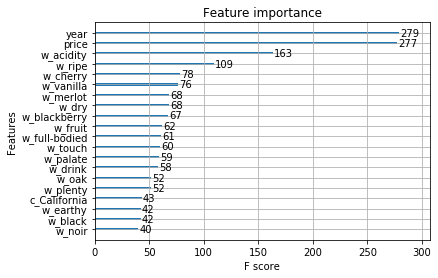

In [13]:
xgb.plot_importance(f_model, importance_type="weight", max_num_features=20)

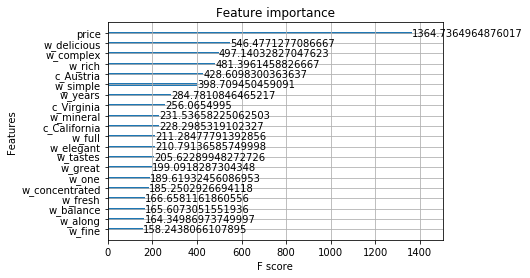

In [14]:
xgb.plot_importance(f_model, importance_type="gain", max_num_features=20)

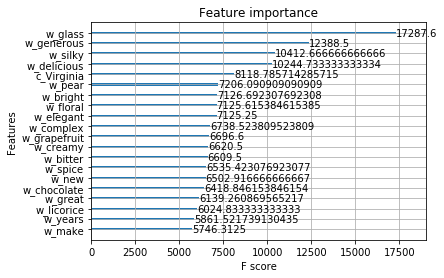

In [15]:
xgb.plot_importance(f_model, importance_type="cover", max_num_features=20)
